# Classification of Dog images

This notebook includes the data extraction, storage in s3 and processing of images of different breeds of dogs.

There are overall 133 different dog breeds about which good image data is available. It is of interest to train a classifier based upon a standard deep convolutional neural network architecture to classify dog images.

The project proceeds in the following phases:

1. Data acquisition and storage in s3
2. Hyperparameter tuning of a classifier constructed using a premade neural network achitecture
3. Profiling and debugging of the training job for the optimal hyperparameters to identify potential issues in the model configuration. 



In [2]:
!pip install smdebug

  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)

[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip


In [6]:
import sagemaker
import boto3

## Dataset

The data contains images of dogs broken up into 133 distinct breeds. The data has been additionally broken up into premade training, validation and test datasets.

I have chosen to train a classifier which is capable of identifying the dog breed from a dog image.

The data is acquired from the udacity dogImages mirror hosted on aws.


In [5]:
# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip


--2022-07-19 10:16:16--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.192.40
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.192.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  46.9MB/s    in 23s     

2022-07-19 10:16:50 (46.1 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.Af

In [19]:

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = 'dog-breed-data'

data_input = sagemaker_session.upload_data(path = './dogImages', bucket= bucket, key_prefix=prefix)

During work on this project, for some reason my Udacity provided AWS account stopped working. As a result, I spun up my own AWS instance but this meant that I needed to be quite parsimonious with the instance types I used for the training work and where I wanted to use larger instance sizes, needed to ask AWS to increase the quota for access.

All of this meant that parts of this could not be completed at the same time as I did other parts which necessitated some pieces of code like the one below which gets the data_input variable without needing to complete the upload.

In [3]:


sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = 'dog-breed-data'

In [4]:
bucket

'sagemaker-ap-southeast-2-494389057463'

In [5]:
data_input = f's3://{bucket}/{prefix}'

In [6]:
print(data_input)

s3://sagemaker-ap-southeast-2-494389057463/dog-breed-data


## Hyperparameter Tuning

I have elected the finetune the RESNET18 network with three hyperparameters. These hyperparameters are:

1. learning rate
2. batch size for both training and evaluation
3. The number of training epochs.

Learning rate is a parameter which affects how quickly a neural network's weights are adjusted in response to training inputs. Learning rate needs to be chosen optimally so that the model learns sufficiently quickly without becoming unstable or learning a suboptimal set of weights for the problem. I have elected to train this parameter between 1e-3 and 1e-1. This range provides a good snapshot of likely optimal rnages for this parameter that I have encountered in the past.

Batch size controls the number of training examples a network is allowed to evaluate prior to having its weights adjusted from the output error term. Setting a large batch size can result in speeding up training by reducing the total number of updates to the weights of hte model. However, performing small batch updates to the weights can result in better training performance by allowing the model to learn from specific examples. Overly large batch sizes will tend to average the effect of traiining. I have elected four  values between 32 and 256. These values will provide a reasonable range in which to tune parameters and none is either too small or too large given the size of the training dataset. 

Epochs controls the number of times the training examples are shown to the model to adjust the weights. Increasing the number of epochs can allow the model to have greater exposure to the training dataset and improve the training performance. However, too many epochs can result in the model overfitting to the training data and a decline in test-set performance. The reason I have chosen the intergar range from 2 to 8 is to balance cost against potential performance given the amount of training data and the relatively high cost of increasing the number of epochs above a certain threshold.

In [7]:
import sagemaker
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)


from sagemaker.pytorch import PyTorch

role = sagemaker.get_execution_role()

In [10]:
estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.g4dn.xlarge"
)

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.01, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128, 256]),
    "epochs": IntegerParameter(2, 8)
}

objective_metric_name = "Average test loss:"
objective_type = "Minimize"
metric_definitions = [{"Name": "Average test loss:", "Regex": "Average test loss: ([0-9\\.]+)"}]

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=8,
    max_parallel_jobs=1,
    objective_type=objective_type,
)

tuner.fit({"training": data_input})


No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [11]:
best_estimator = tuner.best_estimator()


2022-08-05 09:17:45 Starting - Preparing the instances for training
2022-08-05 09:17:45 Downloading - Downloading input data
2022-08-05 09:17:45 Training - Training image download completed. Training in progress.
2022-08-05 09:17:45 Uploading - Uploading generated training model
2022-08-05 09:17:45 Completed - Training job completed


In [12]:
best_estimator.hyperparameters()

{'_tuning_objective_metric': '"Average test loss:"',
 'batch-size': '"64"',
 'epochs': '7',
 'lr': '0.02771502631384128',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-08-05-08-59-51-508"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"ap-southeast-2"',
 'sagemaker_submit_directory': '"s3://sagemaker-ap-southeast-2-494389057463/pytorch-training-2022-08-05-08-59-51-508/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging

In order to finetune the model, I have set a number of sagemaker rule configs and two profiling rules.

The debugger rules I have set are:

1. Vanishing Gradients
   - Monitoring the gradients of the loss function to determine if weights are not adjusting because the gradients are too small
2. Overfitting
   - Overfitting occurs when the model learns the specific features of training data and is unable to generalise
3. Overtraining
   - Related to Overfitting. 
4. Poor weight initialisation
   - If weights fall out of an optimal range when randomly initialised upon startup, the model will struggle to learn the required features.
5. Loss Not Decreasing
   - Monitors if the model's loss function is not decreasing over training to alert the user that the model is no longer learning.
   
The profiler configs I have set include:

1. Lower GPU Utilisation
2. A profiler report config to enable a report to be generated. 

The outputs from this report can be used to determine if changes need to made to the model prior to deployment

In [33]:
from sagemaker.debugger import Rule, ProfilerRule, rule_configs, CollectionConfig
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile

rules = [Rule.sagemaker(rule_configs.vanishing_gradient(), collections_to_save=[CollectionConfig(name = 'gradients',
                                                                                                        parameters = {
                                                                                                            'train.save_interval': '50',
                                                                                                            'eval.save_interval': '5'
                                                                                                        }
                                                                                                        )]),
         Rule.sagemaker(rule_configs.overfit()),
         Rule.sagemaker(rule_configs.overtraining()),
         Rule.sagemaker(rule_configs.poor_weight_initialization(), collections_to_save=[CollectionConfig(name = 'weights',
                                                                                                        parameters = {
                                                                                                            'train.save_interval': '50',
                                                                                                            'eval.save_interval': '5'
                                                                                                        }
                                                                                                        )]),
         Rule.sagemaker(rule_configs.loss_not_decreasing(), collections_to_save=[CollectionConfig(name="losses",
                                                                                                  parameters={
                                                                                                      "train.save_interval": "50",
                                                                                                      "eval.save_interval": "5"
                                                                                                  }
                                                                                                 )]),
         ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
         ProfilerRule.sagemaker(rule_configs.ProfilerReport())
        ]




profiler_config = ProfilerConfig(system_monitor_interval_millis=500, 
                                 framework_profile_params=FrameworkProfile(num_steps=10))

debugger_config = DebuggerHookConfig(hook_parameters={"train.save_interval": "50",
                                                      "eval.save_interval": "5"
                                                     })


In [4]:
#extracted manually because I ran this over several days and needed not to hold everything in memory all the time

hyperparameters = {'batch_size': 64,
                   'epochs': 7,
                   'lr': 0.02771502631384128}

In [34]:

from sagemaker.pytorch import PyTorch

estimator =  PyTorch(
                    entry_point = 'train_model.py',
                    role = role,
                    instance_count = 1,
                    instance_type = "ml.g4dn.xlarge",
                    hyperparameters = hyperparameters,
                    framework_version = '1.8',
                    py_version='py36',
                    profiler_config = profiler_config,
                    debugger_hook_config= debugger_config,
                    rules = rules)



In [35]:
estimator.fit(wait = True)

2022-08-06 01:18:36 Starting - Starting the training job...
2022-08-06 01:19:01 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LossNotDecreasing: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2022-08-06 01:20:02 Downloading - Downloading input data...
2022-08-06 01:20:22 Training - Downloading the training image..........................bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-08-06 01:24:42,317 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-08-06 01:24:42,339 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-08-06 01:24:42,348 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-08-06 01:24:42,855 sagemaker-training-toolkit INFO     Invoking user scrip

In [36]:
!aws s3 ls {estimator.latest_job_debugger_artifacts_path()} --recursive

2022-08-06 01:34:55          0 pytorch-training-2022-08-06-01-18-35-560/debug-output/claim.smd
2022-08-06 01:35:08       4836 pytorch-training-2022-08-06-01-18-35-560/debug-output/collections/000000000/worker_0_collections.json
2022-08-06 01:35:06   47278293 pytorch-training-2022-08-06-01-18-35-560/debug-output/events/000000000000/000000000000_worker_0.tfevents
2022-08-06 01:35:59   47278434 pytorch-training-2022-08-06-01-18-35-560/debug-output/events/000000000050/000000000050_worker_0.tfevents
2022-08-06 01:36:36   47278481 pytorch-training-2022-08-06-01-18-35-560/debug-output/events/000000000100/000000000100_worker_0.tfevents
2022-08-06 01:36:40   45985223 pytorch-training-2022-08-06-01-18-35-560/debug-output/events/000000000105/000000000105_worker_0.tfevents
2022-08-06 01:36:43   45985223 pytorch-training-2022-08-06-01-18-35-560/debug-output/events/000000000110/000000000110_worker_0.tfevents
2022-08-06 01:36:47   45985266 pytorch-training-2022-08-06-01-18-35-560/debug-output/events/

In [53]:
estimator.latest_job_debugger_artifacts_path()

's3://sagemaker-ap-southeast-2-494389057463/pytorch-training-2022-08-06-01-18-35-560/debug-output'

In [37]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2022-08-06 01:46:41.804 datascience-1-0-ml-t3-medium-3d4e057476cc49f3a2c301be5c0b:18 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-ap-southeast-2-494389057463/pytorch-training-2022-08-06-01-18-35-560/debug-output


In [38]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

[2022-08-06 01:46:44.009 datascience-1-0-ml-t3-medium-3d4e057476cc49f3a2c301be5c0b:18 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-ap-southeast-2-494389057463/pytorch-training-2022-08-06-01-18-35-560/debug-output


In [39]:
trial.tensor_names

[2022-08-06 01:46:47.511 datascience-1-0-ml-t3-medium-3d4e057476cc49f3a2c301be5c0b:18 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-08-06 01:46:48.530 datascience-1-0-ml-t3-medium-3d4e057476cc49f3a2c301be5c0b:18 INFO trial.py:210] Loaded all steps


<bound method Trial.tensor_names of <smdebug.trials.s3_trial.S3Trial object at 0x7f30282d0e10>:(
    name=debug-output,
    path=s3://sagemaker-ap-southeast-2-494389057463/pytorch-training-2022-08-06-01-18-35-560/debug-output/,
    steps=[0, 50, 100, 105, 110, 115, 164, 214, 225, 230, 235, 278, 328, 345, 350, 355, 392, 442, 465, 470, 475, 506, 556, 585, 590, 620, 670, 700, 705, 710, 734, 784, 820, 825, 830],
    collections=['all', 'gradients', 'default', 'biases', 'losses', 'weights'],
    tensor_names=['CrossEntropyLoss_output_0', 'ResNet_bn1.weight', 'ResNet_conv1.weight', 'ResNet_fc.0.weight', 'ResNet_fc.2.weight', 'ResNet_layer1.0.bn1.weight', 'ResNet_layer1.0.bn2.weight', 'ResNet_layer1.0.conv1.weight', 'ResNet_layer1.0.conv2.weight', 'ResNet_layer1.1.bn1.weight', 'ResNet_layer1.1.bn2.weight', 'ResNet_layer1.1.conv1.weight', 'ResNet_layer1.1.conv2.weight', 'ResNet_layer2.0.bn1.weight', 'ResNet_layer2.0.bn2.weight', 'ResNet_layer2.0.conv1.weight', 'ResNet_layer2.0.conv2.weight', '

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


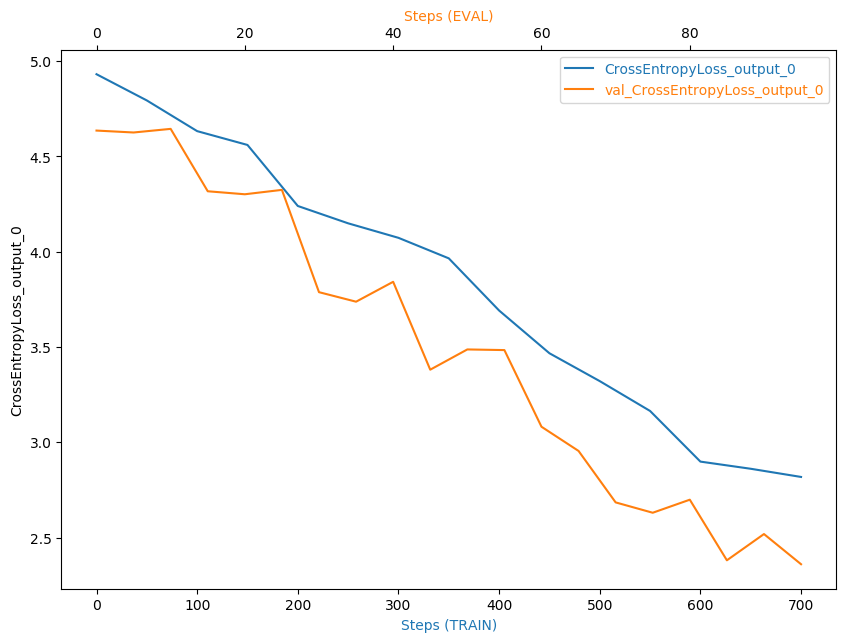

In [40]:
plot_tensor(trial, 'CrossEntropyLoss_output_0')

In [42]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

Copy the html profiler report from the server

In [43]:
! aws s3 ls {rule_output_path} --recursive

2022-08-06 01:45:51     428338 pytorch-training-2022-08-06-01-18-35-560/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-08-06 01:45:50     285876 pytorch-training-2022-08-06-01-18-35-560/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-08-06 01:45:45        537 pytorch-training-2022-08-06-01-18-35-560/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-08-06 01:45:45      38582 pytorch-training-2022-08-06-01-18-35-560/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-08-06 01:45:45       2101 pytorch-training-2022-08-06-01-18-35-560/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-08-06 01:45:45        325 pytorch-training-2022-08-06-01-18-35-560/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-08-06 01:45:45       4693 pytorch-training-2022-08-06-01-18-35-560/rule-output/ProfilerReport/profiler-output/profiler-re

In [44]:
! aws s3 cp {rule_output_path+'/ProfilerReport/profiler-output/profiler-report.html'} profiler_report_1.html

download: s3://sagemaker-ap-southeast-2-494389057463/pytorch-training-2022-08-06-01-18-35-560/rule-output/ProfilerReport/profiler-output/profiler-report.html to ./profiler_report_1.html


The following is the profiler report output.

In [45]:
from IPython.display import display, HTML, IFrame
display(HTML('profiler_report_1.html'))

In [46]:
from smdebug.profiler.system_metrics_reader import S3SystemMetricsReader
#from smdebug.profiler.analysis.notebook_utils.metrics_histogram import MetricsHistogram


path = estimator.latest_job_profiler_artifacts_path()
system_metrics_reader = S3SystemMetricsReader(path)


system_metrics_reader.refresh_event_file_list()
#metrics_histogram = MetricsHistogram(system_metrics_reader)

In [48]:
!pip install --upgrade Flask werkzeug==2.0.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 1.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.2/289.2 kB 3.8 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.1/101.1 kB 1.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.6/95.6 kB 1.4 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 kB 1.6 MB/s eta 0:00:00ta 0:00:01
  Attempting uninstall: werkzeug
    Found existing installation: Werkzeug 1.0.0
    Uninstalling Werkzeug-1.0.0:
      Successfully uninstalled Werkzeug-1.0.0
  Attempting uninstall: itsdangerous
    Found existing installation: itsdangerous 1.1.0
    Uninstalling itsdangerous-1.1.0:
      Successfully uninstalled itsdangerous-1.1.0
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 1.5.0
    Uninstalling importlib-metadata-1.5.0:
      Successfully uninstalled importlib-metadata-1.5.0
  Attempting unins

In [50]:
from jinja2.utils import markupsafe
markupsafe.Markup()

Markup('')

In [51]:
from smdebug.profiler.analysis.notebook_utils.metrics_histogram import MetricsHistogram

ImportError: cannot import name 'Markup' from 'jinja2' (/opt/conda/lib/python3.7/site-packages/jinja2/__init__.py)

In [37]:
events = system_metrics_reader.get_events(start_time=system_metrics_reader.get_timestamp_of_first_available_file(), 
                                          end_time=system_metrics_reader.get_timestamp_of_latest_available_file())

[2022-08-05 12:08:31.071 datascience-1-0-ml-t3-medium-3d4e057476cc49f3a2c301be5c0b:19 INFO metrics_reader_base.py:134] Getting 26 event files


In [41]:
events[0].dimension

'GPUUtilization'

In [20]:
system_metrics_reader.get_timestamp_of_latest_available_file()

1659699600000000

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [ ]:
# TODO: Display the profiler output

## Model Deploying

In [ ]:
# TODO: Deploy your model to an endpoint

predictor=estimator.deploy() # TODO: Add your deployment configuration like instance type and number of instances

In [ ]:
# TODO: Run an prediction on the endpoint

image = # TODO: Your code to load and preprocess image to send to endpoint for prediction
response = predictor.predict(image)

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()